In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D, add, Input, Activation
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adadelta, RMSprop, Nadam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
import wandb
from wandb.keras import WandbCallback

In [2]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [3]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)


In [4]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)


Compute dtype: float16
Variable dtype: float32


In [5]:
((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

In [6]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

labelNames = ["airplane", "automobile", "bird", "cat", "deer",
"dog", "frog", "horse", "ship", "truck"]

In [7]:
aug = ImageDataGenerator(width_shift_range=0.1,
                height_shift_range=0.1, horizontal_flip=True,fill_mode="nearest")

In [8]:
def residual_module(data, K, stride, chanDim,
                    reg=0.0001, bnEps=2e-5, bnMom=0.9, reduce=False):
    
    shortcut = data
    
    bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(data)
    act1 = Activation("relu")(bn1)
    
    conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
                kernel_regularizer=l2(reg))(act1)
    
    
    bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                momentum=bnMom)(conv1)
    act2 = Activation("relu")(bn2)
    conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
                padding="same", use_bias=False,
    kernel_regularizer=l2(reg))(act2)
    
    
    bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                momentum=bnMom)(conv2)
    act3 = Activation("relu")(bn3)
    conv3 = Conv2D(K, (1, 1), use_bias=False,
                kernel_regularizer=l2(reg))(act3)
    
    
    
    if reduce:
        shortcut = Conv2D(K, (1, 1), strides=stride,
            use_bias=False, kernel_regularizer=l2(reg))(act1)
    
    x = add([conv3, shortcut])
    
    
    
    return x

In [9]:
def build_Resnet(width, height, depth, classes, stages, filters,
                reg=0.0001, bnEps=2e-5, bnMom=0.9):
    
    
    inputShape = (height, width, depth)
    chanDim = -1
    inputs = Input(shape=inputShape)
    x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                            momentum=bnMom)(inputs)
    x = Conv2D(filters[0], (3, 3), use_bias=False,padding="same", kernel_regularizer=l2(reg))(x)
    
    
    
    for i in range(0, len(stages)):

        stride = (1, 1) if i == 0 else (2, 2)
        
        x = residual_module(x, filters[i + 1], stride,
                chanDim, reduce=True, bnEps=bnEps, bnMom=bnMom)
        
        for j in range(0, stages[i] - 1):
            
            x = residual_module(x, filters[i + 1],
                    (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)
            
    x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                            momentum=bnMom)(x)
    x = Activation("relu")(x)
    x = AveragePooling2D((8, 8))(x) 
    x = Flatten()(x)
    x = Dense(classes, kernel_regularizer=l2(reg))(x)
    x = Activation("softmax", dtype='float32')(x)
    
    model = Model(inputs, x, name="resnet")
    
    
    
    return model



In [10]:
# NUM_EPOCHS = 100
# INIT_LR = 1e-2

# def poly_decay(epoch):
#     maxEpochs = NUM_EPOCHS
#     baseLR = INIT_LR
#     power = 1.0
#     alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
#     return alpha

In [10]:
model = build_Resnet(32, 32, 3, 10, (9, 9, 9),
                                (64, 64, 128, 256), reg=0.05)

In [11]:
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d[0][0]                     
_____________________________________________________________________________________________

In [12]:
Batch_size = 1024
lr = 2e-2
epochs = 100

# callbacks = [LearningRateScheduler(poly_decay)]


#opt = SGD(lr= lr, momentum= 0.9, nesterov=True)
#opt = SGD(lr= lr ,decay = ,  momentum= 0.9, nesterov=True)
#
#opt = Adam(lr=lr,amsgrad=True)


# s = 100 * len(trainX) // Batch_size # number of steps in 20 epochs (batch size = 32)
# learning_rate0 = keras.optimizers.schedules.ExponentialDecay(lr, s, 0.96)

opt = Adam(learning_rate=lr , beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.004, amsgrad=True)


metric = "val_accuracy"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

checkpoint = ModelCheckpoint("ResNet_Cifar10_best.h5", monitor= metric, verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto')


In [13]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [14]:
Resnet = model.fit(aug.flow(trainX, trainY, batch_size= Batch_size), validation_data = (testX, testY)
                       ,steps_per_epoch=len(trainX) // Batch_size, epochs= epochs, verbose= 1,
                  callbacks=[es,checkpoint])

Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 3.1595 - accuracy: 0.2525
Epoch 00001: val_accuracy improved from -inf to 0.21600, saving model to ResNet_Cifar10_best.h5
48/48 [==============================] - 22s 466ms/step - loss: 3.1595 - accuracy: 0.2525 - val_loss: 2.7119 - val_accuracy: 0.2160
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 2.2040 - accuracy: 0.3681
Epoch 00002: val_accuracy improved from 0.21600 to 0.30890, saving model to ResNet_Cifar10_best.h5
48/48 [==============================] - 22s 452ms/step - loss: 2.2040 - accuracy: 0.3681 - val_loss: 2.2733 - val_accuracy: 0.3089
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 1.8912 - accuracy: 0.4494
Epoch 00003: val_accuracy improved from 0.30890 to 0.38980, saving model to ResNet_Cifar10_best.h5
48/48 [==============================] - 22s 452ms/step - loss: 1.8912 - accuracy: 0.4494 - val_loss: 1.9945 - val_accuracy: 0.3898
Epoch 4/100
48/48 [======

Epoch 28/100
48/48 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.8764
Epoch 00028: val_accuracy did not improve from 0.82120
48/48 [==============================] - 20s 427ms/step - loss: 0.6204 - accuracy: 0.8764 - val_loss: 0.8073 - val_accuracy: 0.8187
Epoch 29/100
48/48 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.8833
Epoch 00029: val_accuracy improved from 0.82120 to 0.84850, saving model to ResNet_Cifar10_best.h5
48/48 [==============================] - 21s 448ms/step - loss: 0.6040 - accuracy: 0.8833 - val_loss: 0.7171 - val_accuracy: 0.8485
Epoch 30/100
48/48 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.8845
Epoch 00030: val_accuracy did not improve from 0.84850
48/48 [==============================] - 21s 428ms/step - loss: 0.5956 - accuracy: 0.8845 - val_loss: 0.8046 - val_accuracy: 0.8220
Epoch 31/100
48/48 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.8903
Epoch 00031

48/48 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.9398
Epoch 00056: val_accuracy did not improve from 0.87320
48/48 [==============================] - 20s 407ms/step - loss: 0.3823 - accuracy: 0.9398 - val_loss: 0.6844 - val_accuracy: 0.8554
Epoch 57/100
48/48 [==============================] - ETA: 0s - loss: 0.3835 - accuracy: 0.9396
Epoch 00057: val_accuracy improved from 0.87320 to 0.88450, saving model to ResNet_Cifar10_best.h5
48/48 [==============================] - 20s 419ms/step - loss: 0.3835 - accuracy: 0.9396 - val_loss: 0.5630 - val_accuracy: 0.8845
Epoch 58/100
48/48 [==============================] - ETA: 0s - loss: 0.3782 - accuracy: 0.9398
Epoch 00058: val_accuracy did not improve from 0.88450
48/48 [==============================] - 20s 414ms/step - loss: 0.3782 - accuracy: 0.9398 - val_loss: 0.6102 - val_accuracy: 0.8751
Epoch 59/100
48/48 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.9405
Epoch 00059: val_accurac

48/48 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.9650
Epoch 00084: val_accuracy did not improve from 0.89640
48/48 [==============================] - 21s 435ms/step - loss: 0.2834 - accuracy: 0.9650 - val_loss: 0.5986 - val_accuracy: 0.8810
Epoch 85/100
48/48 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.9643
Epoch 00085: val_accuracy did not improve from 0.89640
48/48 [==============================] - 21s 428ms/step - loss: 0.2830 - accuracy: 0.9643 - val_loss: 0.5665 - val_accuracy: 0.8868
Epoch 86/100
48/48 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.9637
Epoch 00086: val_accuracy improved from 0.89640 to 0.89750, saving model to ResNet_Cifar10_best.h5
48/48 [==============================] - 21s 437ms/step - loss: 0.2847 - accuracy: 0.9637 - val_loss: 0.5263 - val_accuracy: 0.8975
Epoch 87/100
48/48 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.9669
Epoch 00087: val_accurac

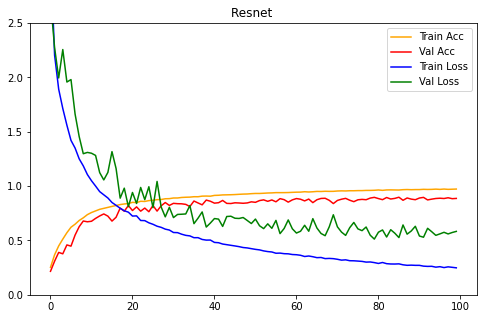

In [15]:
plt.figure(figsize=(8,5))
# plt.plot(np.arange(0,31),history.history['accuracy'], color='orange')
# plt.plot(np.arange(0,31),history.history['loss'],'b')
# plt.plot(np.arange(0,31)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
# plt.plot(np.arange(0,31)+0.5,history.history['val_loss'],'g')
plt.plot(Resnet.history['accuracy'],color='orange')
plt.plot(Resnet.history['val_accuracy'],'r')
plt.plot(Resnet.history['loss'],'b')
plt.plot(Resnet.history['val_loss'],'g')
plt.legend(['Train Acc','Val Acc','Train Loss','Val Loss'])
#plt.grid()
plt.gca().set_ylim(0, 2.5) # set the vertical range to [0-1] 
plt.title("Resnet ")
plt.savefig("Resnet_1024 Batch", dpi=300,  bbox_inches='tight')
plt.show()